# Anomaly detection using a global normalization

In [1]:
using CABLAB

In this example we combine the subsample-quantile approach with the extreme event detection methods. We first take some sample grid cells out of the cube, calculate the 40% and 60% quantile to normalize the variables against each other. We also use this subsample to train the optimization parameters used for the extreme event detectioon methods. 

In [2]:
c=Cube("/home/jovyan/work/datacube/cablab-datacube-0.2.3/low-res/")
cdata=getCubeData(c,variable=c.dataset_files,longitude=(-10,35),latitude=(30,65)
,variable=["air_temperature_2m","gross_primary_productivity","latent_energy","precipitation"])
cdata_filled=mapCube(gapFillMSC,cdata)
cdata_anom=mapCube(removeMSC,cdata_filled);

In [3]:
sp=sampleLandPoints(cdata,3000)
spfilled=mapCube(gapFillMSC,sp)
spanom=mapCube(removeMSC,spfilled)

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Spatial points axis with 3000 points
Variable            Axis with elements: air_temperature_2m gross_primary_productivity latent_energy precipitation 
Total size: 28.95 MB


In [4]:
spquants = mapCube(CABLAB.Proc.Stats.timespacequantiles,readCubeData(spanom),[0.4,0.6])
spquants.data

2×4 Array{Float32,2}:
 -0.545783  -0.0415214  -0.0228454  -0.394589 
  0.546402   0.0253634   0.0328296  -0.0189299

In [5]:
function scaleCubeQuantiles(xout::AbstractVector,xin::AbstractVector,quantiles)
    absm=(abs(quantiles[1])+abs(quantiles[2]))/2
    for i in eachindex(xin)
        xout[i]=xin[i]/absm
    end
end
registerDATFunction(scaleCubeQuantiles,((TimeAxis,),(QuantileAxis,)),(TimeAxis,),inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1);

The we normalize the cube by dividing each value by the absmean of the 40% and 60% quantile.

In [6]:
cdata_norm=mapCube(scaleCubeQuantiles,(cdata_anom,spquants))

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25
Variable            Axis with elements: air_temperature_2m gross_primary_productivity latent_energy precipitation 
Total size: 243.21 MB


In [7]:
using StatsBase
function getTrainArray(smallcube)
    dmem=readCubeData(smallcube).data;
    sampletimes=rand(1:506,5000)
    sampleplaces=rand(1:2000,5000)
    trainarray=Float64[dmem[sampletimes[i],sampleplaces[i],j] for i=1:5000,j=1:4]
    nnans=squeeze(mapreducedim(isnan,+,trainarray,2),2)
    trainarray=trainarray[nnans.==0,:];
    trainarray
end
trainarray=getTrainArray(spanom)

4405×4 Array{Float64,2}:
 -0.209326   0.350744     0.33421     -0.768961 
 -1.10261   -0.0222464    0.00586587  -1.5435   
 -1.0677     0.0827811    0.0642904    2.16158  
  1.24132    0.19775      0.715022    -0.229081 
 -1.34973    0.0882333    0.00697108  -0.240372 
  3.01235    0.0269953   -0.138506     1.68434  
 -1.78826   -0.165937     0.0161557   -0.104027 
 -0.33409   -0.191821    -0.205402     1.8565   
  0.434479  -0.208073    -0.404005     0.0889951
 -0.494668   0.0552528    0.127578    -0.208675 
  3.2626    -0.38199      0.0518057    0.562867 
 -2.22778   -0.148382    -0.160125     1.29571  
 -0.909593   0.564183     0.34291     -3.30821  
  ⋮                                             
 -1.1572    -0.0967919   -0.0776562   -0.275253 
  2.96762    0.00258721   0.132133    -1.05693  
  0.909402  -0.0992698   -0.305741    -1.5681   
 -0.330228   0.612018     0.353512     0.75452  
  2.86683    0.00920796  -0.00886681  -0.0894336
 -4.3004    -0.16545     -0.148316     0.539

In [8]:
addprocs(10);

In [8]:
@time xout2=mapCube(DAT_detectAnomalies!,cdata_norm,["REC", "KDE", "KNN_Gamma"],trainarray)

560.419479 seconds (56.95 M allocations: 4.415 GB, 0.26% gc time)


Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Method              Axis with elements: REC KDE KNN_Gamma 
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25
Total size: 182.41 MB


In [10]:
rmprocs(workers())

:ok

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0
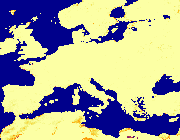

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 0.80 
 0.85 
 0.90 
 0.95 
 1.00
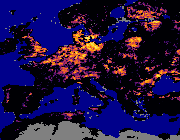

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 
 
 40 
 50 
 60 
 70 
 80 
 90 
 100
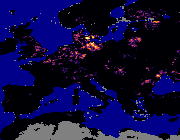

In [9]:
display(plotMAP(xout2,time=160,method=1,dmin=0.5,dmax=1.0))
display(plotMAP(xout2,time=160,method=2,dmin=0.8,dmax=1.0))
display(plotMAP(xout2,time=160,method=3,dmin=40,dmax=100))

In [10]:
meanscore=reduceCube(mean, xout2, TimeAxis, no_ocean=true);

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 0.50 
 0.75 
 1.00
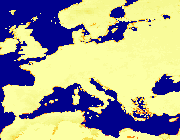

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 0.2 
 0.4 
 0.6
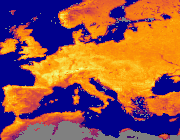

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 10 
 20
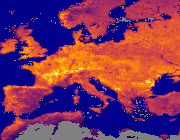

In [11]:
display(plotMAP(meanscore,method=1))
display(plotMAP(meanscore,method=2))
display(plotMAP(meanscore,method=3))

For all methods one can observe the effect of the global normalization. This leads to an overdetection of extremes in the zones where variablility of the underlying variables is highest. 